In [23]:
from itertools import combinations
from rdkit.Chem import rdMolEnumerator,rdDepictor
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addBondIndices = True###显示原子索引
IPythonConsole.drawOptions.addAtomIndices = True###显示原子索引
IPythonConsole.molSize = 600,600
rdDepictor.SetPreferCoordGen(False)

In [2]:
def Smi_DummyAtom(smi='',atoms=[]):##[smi,]
	smis=[]
	for i in atoms:
		mol=Chem.MolFromSmiles('**.'+smi+' |m:0:'+str(i+2)+'|')
		mol_=rdMolEnumerator.Enumerate(mol)[0]
		smis_=Chem.MolToSmiles(mol_)
		smis.append(smis_)
	return list(set(smis))

def Smi_DummyBond(smi='',bonds=[]):##{'smi':[bond],}
	smis={}
	mol=Chem.MolFromSmiles(smi)
	for i in bonds:
		begin=mol.GetBonds()[i].GetBeginAtomIdx()
		end=mol.GetBonds()[i].GetEndAtomIdx()
		mol1=Chem.RWMol(mol)
		mol1.RemoveBond(begin,end)
		mol1.ReplaceAtom(begin,Chem.Atom(0))
		mol1.ReplaceAtom(end,Chem.Atom(0))	
		mol_=mol1.GetMol()
		smis_dummy=Chem.MolToSmiles(mol_)
		#获取虚原子的索引
		dummy_atoms=[]
		for atom in Chem.MolFromSmiles(smis_dummy,False).GetAtoms():
			if atom.GetAtomicNum()==0:
				dummy_atoms.append(atom.GetIdx())
		smis[smis_dummy]=dummy_atoms
	return smis

def handle_core(smi='',atoms=[],bonds=[]):##处理core结构:[smi,[atoms,],[[begin,end],]]
	core_out=[]
	bonds_atomize=[]
	mol=Chem.MolFromSmiles(smi)
	smi_out=Chem.MolToSmiles(mol)
	for i in bonds:
		begin=mol.GetBonds()[i].GetBeginAtomIdx()
		end=mol.GetBonds()[i].GetEndAtomIdx()
		bonds_atomize.append([begin,end])
		bonds_atomize.append([end,begin])
	core_out=[smi_out,atoms,bonds_atomize]
	return core_out

In [ ]:
Chem.MolFromSmiles('C1=CC=C(C2=CC=CC=C2)C2=CC(C3=CC=CC=C3)=C(C3=CC=CC=C3)C=C12')

In [4]:
dummy_atoms_ligand_smi=Smi_DummyAtom(smi='C1=CC=C(C2=CC=CC=C2)C2=CC(C3=CC=CC=C3)=C(C3=CC=CC=C3)C=C12',atoms=[5,6,7,8,9])
dummy_bonds_ligand_smi=Smi_DummyBond(smi='C1=CC=C(C2=CC=CC=C2)C2=CC(C3=CC=CC=C3)=C(C3=CC=CC=C3)C=C12',bonds=[5,6,7,8])

In [5]:
dummy_atoms_ligand_smi

['*c1ccccc1-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12',
 '*c1cccc(-c2cccc3cc(-c4ccccc4)c(-c4ccccc4)cc23)c1',
 '*c1ccc(-c2cccc3cc(-c4ccccc4)c(-c4ccccc4)cc23)cc1']

In [6]:
dummy_bonds_ligand_smi

{'*:cccc(:*)-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12': [0, 5],
 '*:ccc(c:*)-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12': [0, 5]}

In [33]:
core=[]
core.append(handle_core(smi='C1=CC=CC(C2=CC3=CC=CC=C3C(C3=CC=CC=C3)=C2)=C1',atoms=[10,11,9,8],bonds=[8,9,10]))
core

[['c1ccc(-c2cc(-c3ccccc3)c3ccccc3c2)cc1',
  [10, 11, 9, 8],
  [[8, 9], [9, 8], [9, 10], [10, 9], [10, 11], [11, 10]]]]

In [30]:
##根据一个配体和主核进行atoms位点枚举
def atom_enum(core=[],dummy_atoms_ligand_smi=[],dummy_bonds_ligand_smi={}):##return:[[smi,],]
	smile_out_atoms=[]
	smile_out_bonds=[]
	smile4enum=[]
	for i in core:
		core_smi=i[0]
		core_atoms=i[1]
		core_bonds=i[2]
		##获取core_smi分子式的包含的原子个数
		core_atoms_num=Chem.MolFromSmiles(core_smi).GetNumAtoms()
		##获取core_smi分子式中被选中的虚原子个数
		dummy_atoms_num=len(core_atoms)
		for a_smi in dummy_atoms_ligand_smi:###????
			##获取dummy_atoms_ligand_smi分子式包含的原子个数
			ligand_atoms_num=Chem.MolFromSmiles(dummy_atoms_ligand_smi[0]).GetNumAtoms()
			smi_with_links=[]
			for substitute_num in range(1,dummy_atoms_num+1):
				smile_without_link=core_smi+('.'+a_smi)*substitute_num
				core_site_sets=combinations(core_atoms,substitute_num)
				dummy_site=[]
				for n in range(1,substitute_num+1):
					dummy_site.append(str(core_atoms_num+ligand_atoms_num*(n-1)))
				for core_site_set in core_site_sets:
					smi_link=' |m:'
					for n in range(1,substitute_num+1):
						smi_link=smi_link+str(dummy_site[n-1])+':'+str(core_site_set[n-1])+','
					smi_link=smi_link+'|'
					smi_with_links.append(smile_without_link+smi_link)
				smile4enum.extend(smi_with_links)
	for i in smile4enum:
		molbundle=rdMolEnumerator.Enumerate(Chem.MolFromSmiles(i))
		smile_out_atoms.append(Chem.MolToSmiles(molbundle.GetMol(0)))
	smile_out=[smile_out_atoms,smile_out_bonds]
	return smile_out

		
	

In [31]:
atom_enum(core,dummy_atoms_ligand_smi,dummy_bonds_ligand_smi)

[['c1ccc(-c2cc(-c3ccc(-c4ccccc4-c4cccc5cc(-c6ccccc6)c(-c6ccccc6)cc45)cc3)c3ccccc3c2)cc1',
  'c1ccc(-c2cc(-c3cccc(-c4ccccc4-c4cccc5cc(-c6ccccc6)c(-c6ccccc6)cc45)c3)c3ccccc3c2)cc1',
  'c1ccc(-c2cc(-c3cccc(-c4ccccc4-c4cccc5cc(-c6ccccc6)c(-c6ccccc6)cc45)c3)c3ccccc3c2)cc1',
  'c1ccc(-c2cc(-c3ccccc3-c3ccccc3-c3cccc4cc(-c5ccccc5)c(-c5ccccc5)cc34)c3ccccc3c2)cc1',
  'c1ccc(-c2cc(-c3ccc(-c4ccccc4-c4cccc5cc(-c6ccccc6)c(-c6ccccc6)cc45)cc3)c3ccccc3c2)cc1',
  'c1ccc(-c2cc(-c3cccc(-c4ccccc4-c4cccc5cc(-c6ccccc6)c(-c6ccccc6)cc45)c3)c3ccccc3c2)cc1',
  'c1ccc(-c2cc(-c3cccc(-c4ccccc4-c4cccc5cc(-c6ccccc6)c(-c6ccccc6)cc45)c3)c3ccccc3c2)cc1',
  'c1ccc(-c2cc(-c3ccccc3-c3ccccc3-c3cccc4cc(-c5ccccc5)c(-c5ccccc5)cc34)c3ccccc3c2)cc1',
  'c1ccc(-c2cc(-c3ccc(-c4ccccc4-c4cccc5cc(-c6ccccc6)c(-c6ccccc6)cc45)c(-c4ccccc4-c4cccc5cc(-c6ccccc6)c(-c6ccccc6)cc45)c3)c3ccccc3c2)cc1',
  'c1ccc(-c2cc(-c3ccc(-c4ccccc4-c4cccc5cc(-c6ccccc6)c(-c6ccccc6)cc45)c(-c4ccccc4-c4cccc5cc(-c6ccccc6)c(-c6ccccc6)cc45)c3)c3ccccc3c2)cc1',
  'c1ccc

In [25]:
Chem.MolFromSmiles('CC(=O)Oc1ccccc1C(=O)O').GetNumAtoms()

13

In [21]:
smile4enum

['c1ccc(-c2cc(-c3ccccc3)c3ccccc3c2)cc1.*c1ccccc1-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12 |m:22:10,|',
 'c1ccc(-c2cc(-c3ccccc3)c3ccccc3c2)cc1.*c1ccccc1-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12 |m:22:11,|',
 'c1ccc(-c2cc(-c3ccccc3)c3ccccc3c2)cc1.*c1ccccc1-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12 |m:22:9,|',
 'c1ccc(-c2cc(-c3ccccc3)c3ccccc3c2)cc1.*c1ccccc1-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12 |m:22:8,|',
 'c1ccc(-c2cc(-c3ccccc3)c3ccccc3c2)cc1.*c1ccccc1-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12 |m:22:10,|',
 'c1ccc(-c2cc(-c3ccccc3)c3ccccc3c2)cc1.*c1ccccc1-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12 |m:22:11,|',
 'c1ccc(-c2cc(-c3ccccc3)c3ccccc3c2)cc1.*c1ccccc1-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12 |m:22:9,|',
 'c1ccc(-c2cc(-c3ccccc3)c3ccccc3c2)cc1.*c1ccccc1-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12 |m:22:8,|',
 'c1ccc(-c2cc(-c3ccccc3)c3ccccc3c2)cc1.*c1ccccc1-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12.*c1ccccc1-c1cccc2cc(-c3ccccc3)c(-c3ccccc3)cc12 |m:22:10,51:11,|',
 'c1ccc(-c2cc(-c3ccccc3)c3ccccc3c2)cc1.*c1ccccc1-c1cccc2cc(-

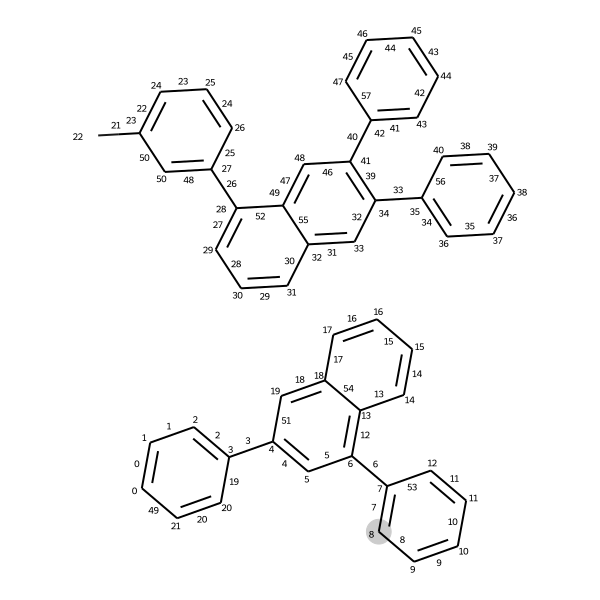

In [136]:
Chem.MolFromSmiles(smile4enum[0])

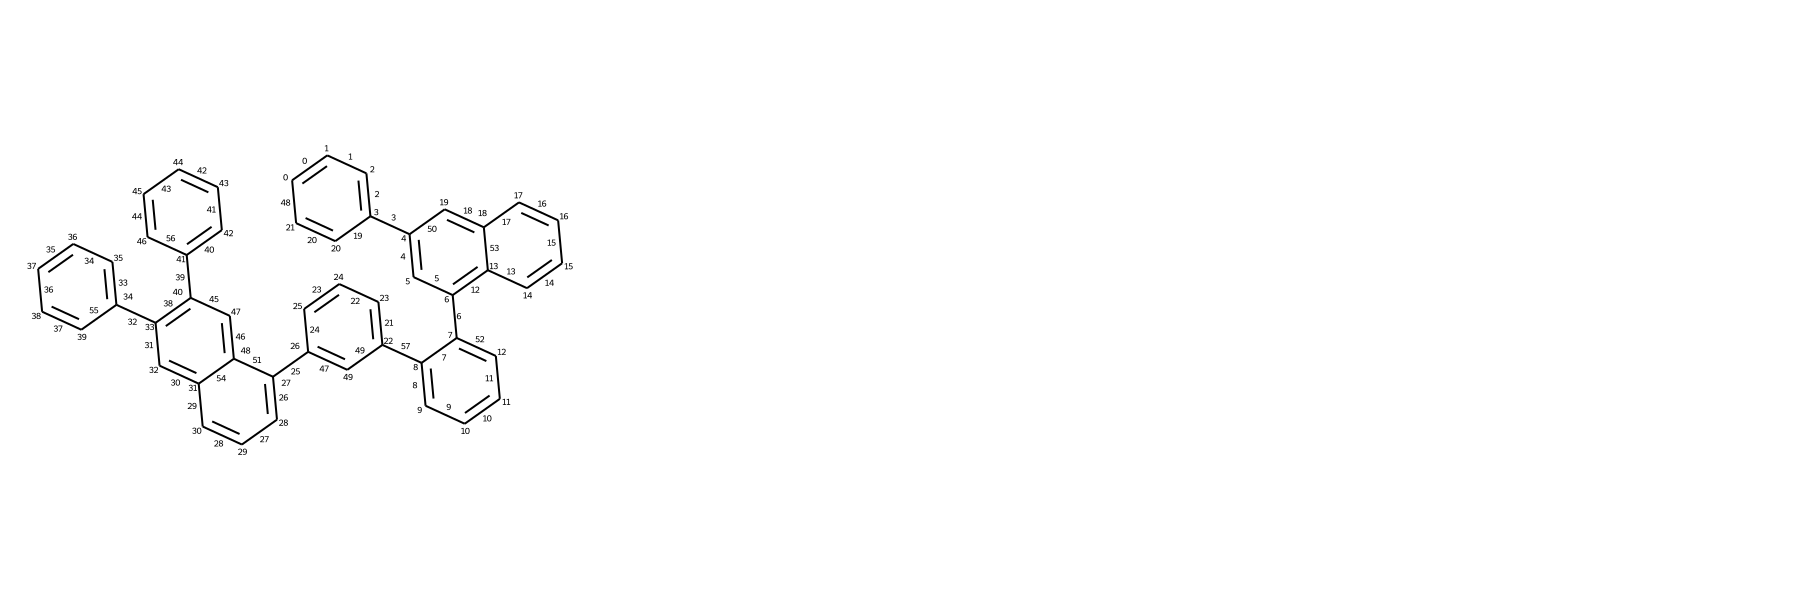

In [137]:
rdMolEnumerator.Enumerate(Chem.MolFromSmiles(smile4enum[0]))

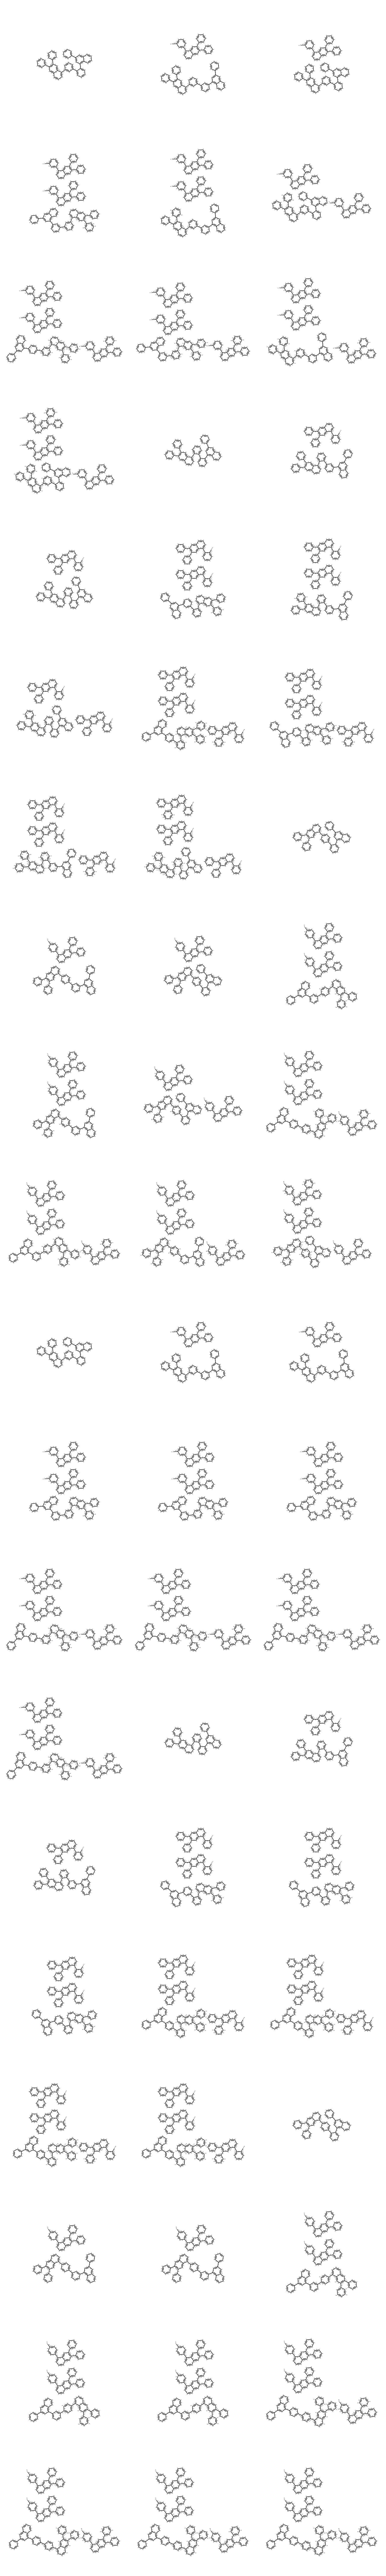

In [21]:
for i in smile4enum:
	molbundle=rdMolEnumerator.Enumerate(Chem.MolFromSmiles(i))
	for mol in molbundle:
		bndl.AddMol(molbundle.GetMol(0))
bndl

In [113]:
list(range(1))

[0]

In [109]:
a='.smile_dummy'*3
a

'.smile_dummy.smile_dummy.smile_dummy'

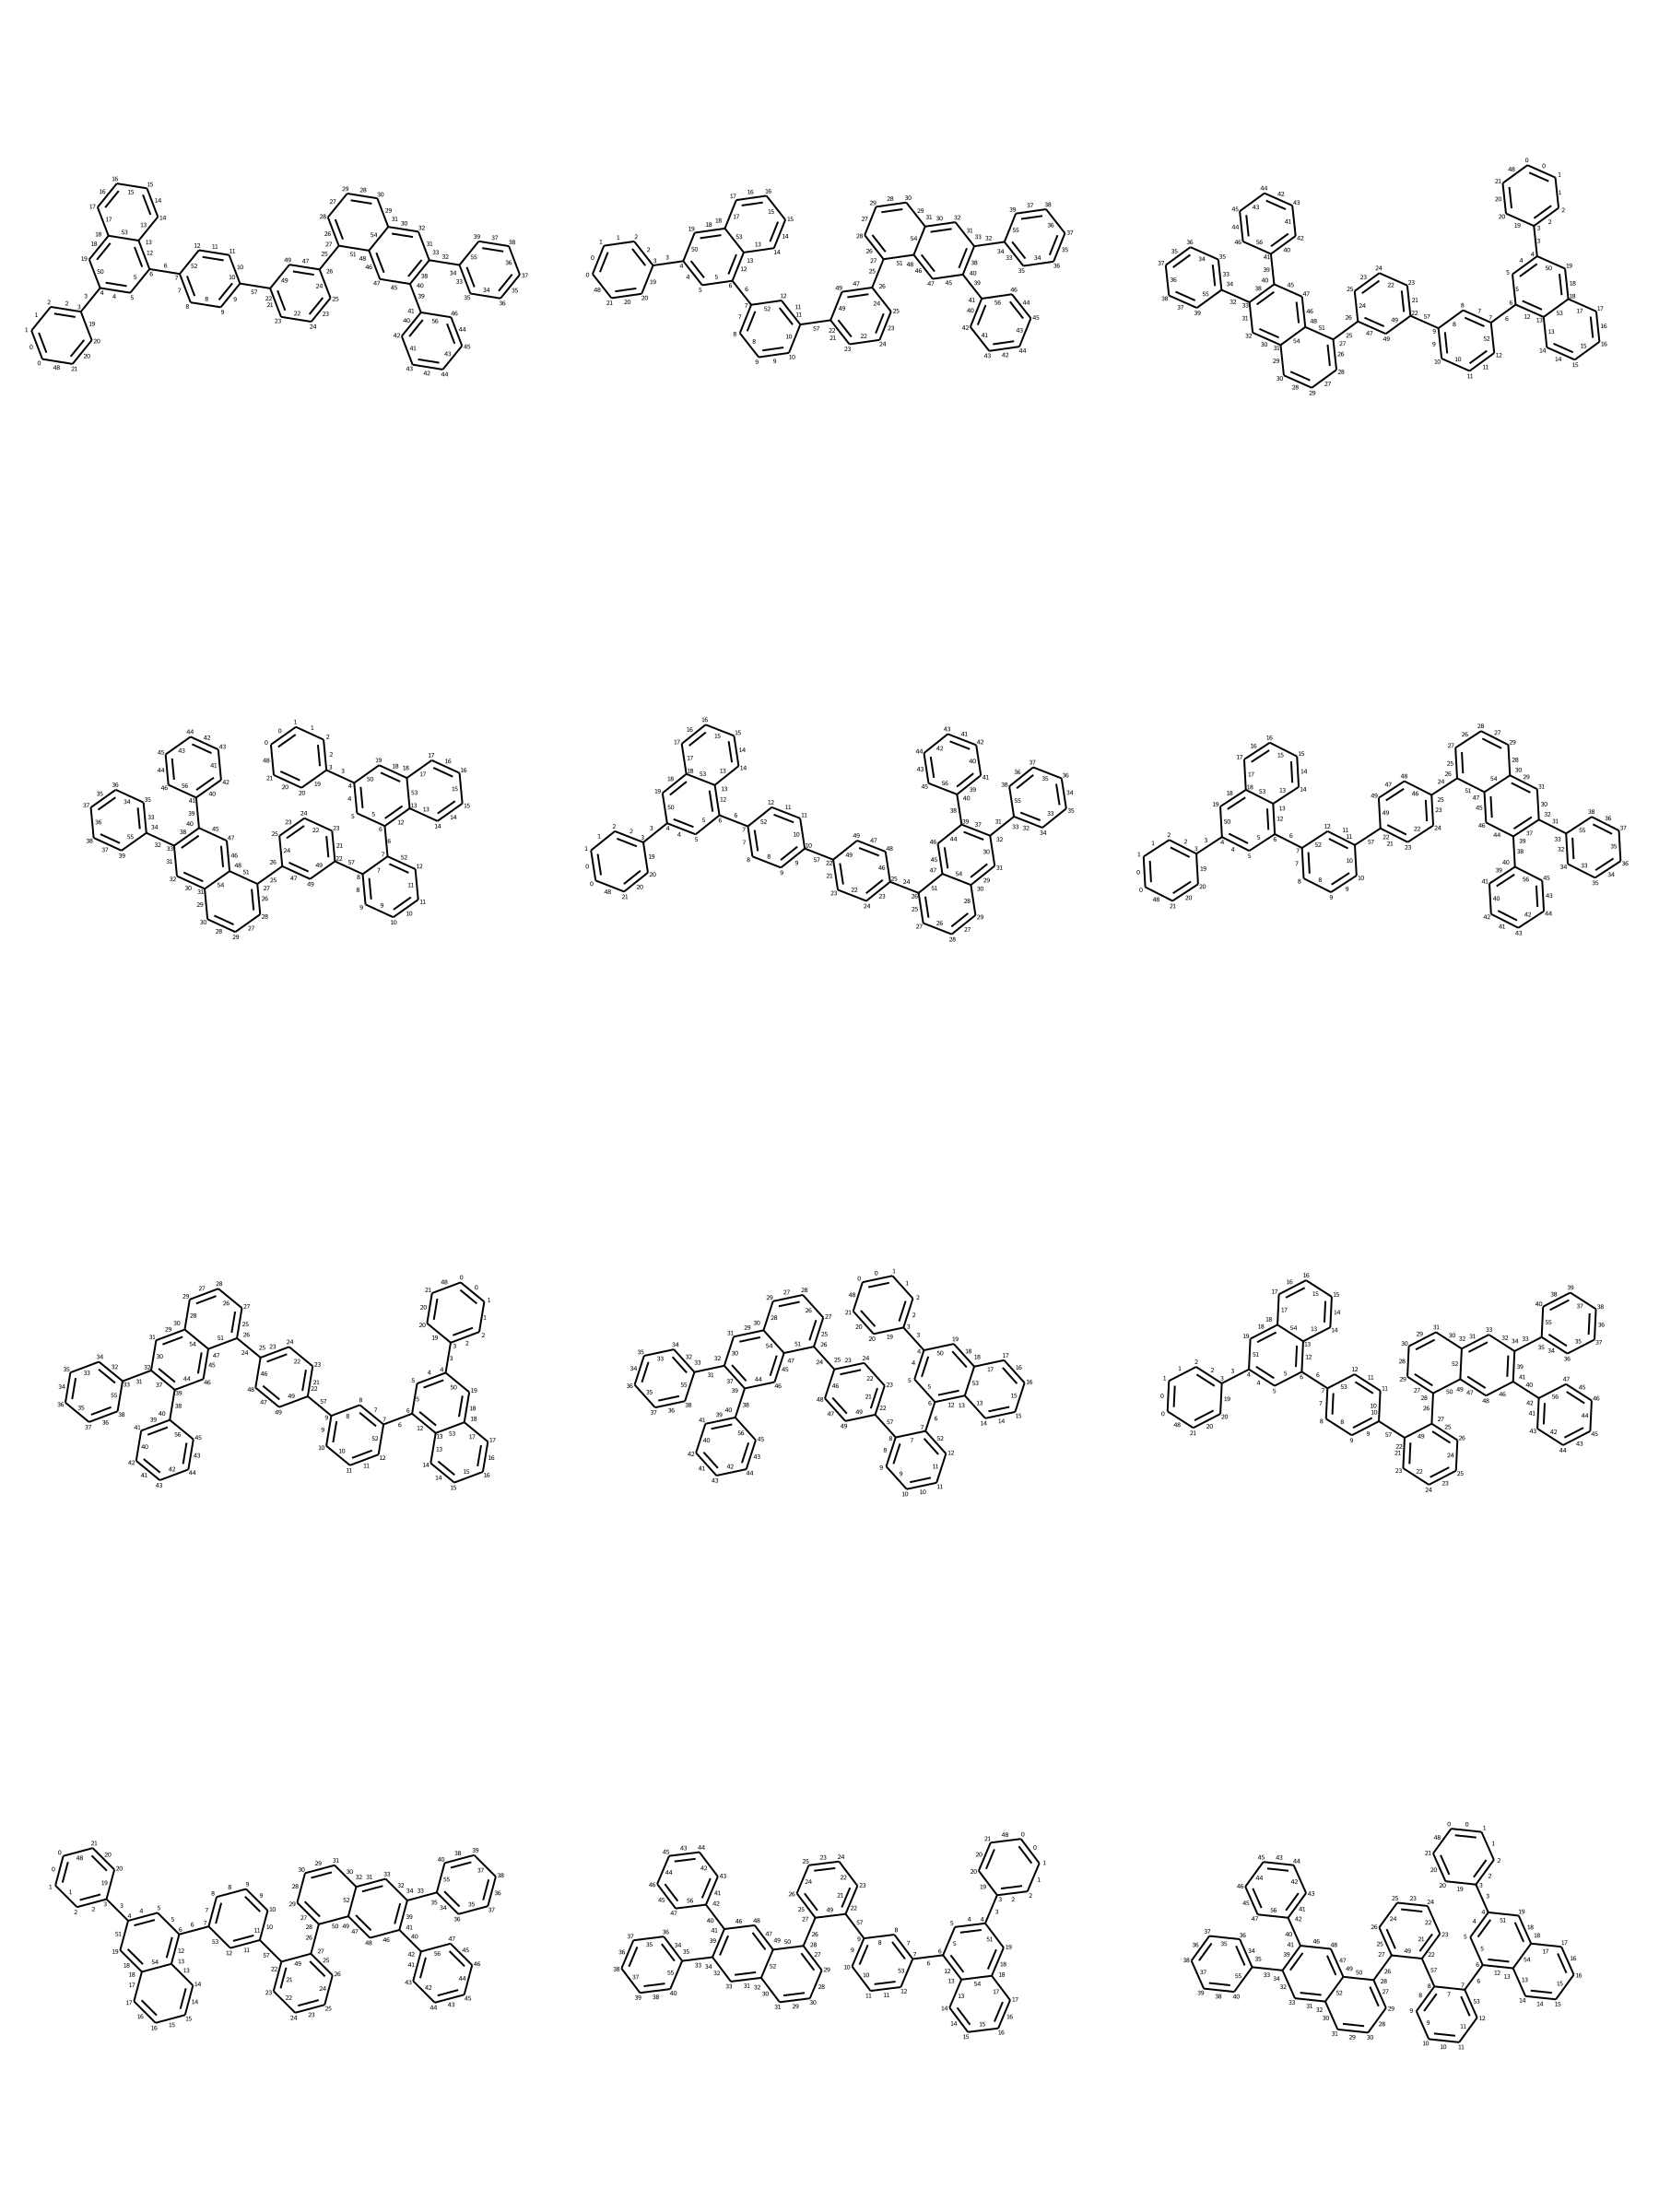

In [99]:
bndl

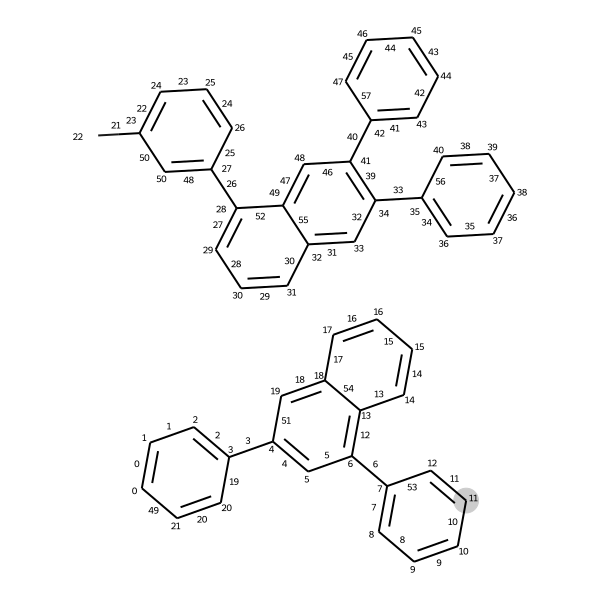

In [96]:
Chem.MolFromSmiles('c1ccc(-c2cc(-c3ccccc3)c3ccccc3c2)cc1.*c1cccc(-c2cccc3cc(-c4ccccc4)c(-c4ccccc4)cc23)c1 |m:22:11|')

In [8]:
smis={}
mol=Chem.MolFromSmiles('C1=CC=CC(C2=CC3=CC=CC=C3C(C3=CC=CC=C3)=C2)=C1')
begin=mol.GetBonds()[10].GetBeginAtomIdx()
end=mol.GetBonds()[10].GetEndAtomIdx()
mol1=Chem.RWMol(mol)
mol1.RemoveBond(begin,end)
mol1.ReplaceAtom(begin,Chem.Atom(0))
mol1.ReplaceAtom(end,Chem.Atom(0))	
mol_=mol1.GetMol()
smis_dummy=Chem.MolToSmiles(mol_)
#获取虚原子的索引
dummy_atoms=[]
for atom in mol_.GetAtoms():
	if atom.GetAtomicNum()==0:
		dummy_atoms.append(atom.GetIdx())
smis[smis_dummy]=dummy_atoms

In [9]:
mol=Chem.MolFromSmiles('C1=CC=CC(C2=CC3=CC=CC=C3C(C3=CC=CC=C3)=C2)=C1')
num=mol.GetNumAtoms()
num

22

In [10]:
side=Smi_DummyBond(smi='C1=CC=CC(C2=CC3=CC=CC=C3C(C3=CC=CC=C3)=C2)=C1',bonds=[10,8,9])
mol1=Chem.MolFromSmiles(list(side.keys())[0],False)
mol1.GetNumAtoms()

22

In [11]:
list(side.keys())[0]

'*:ccc1cc(-c2ccccc2)cc(-c2ccccc2)c1:*'

In [12]:
##处理core结构
def handle_core(smi='',atoms=[],bonds=[]):
	core_out=[]
	bonds_atomize=[]
	mol=Chem.MolFromSmiles(smi)
	smi_out=Chem.MolToSmiles(mol)
	for i in bonds:
		begin=mol.GetBonds()[i].GetBeginAtomIdx()
		end=mol.GetBonds()[i].GetEndAtomIdx()
		bonds_atomize.append([begin,end])
		bonds_atomize.append([end,begin])
	core_out=[smi_out,atoms,bonds_atomize]
	return core_out

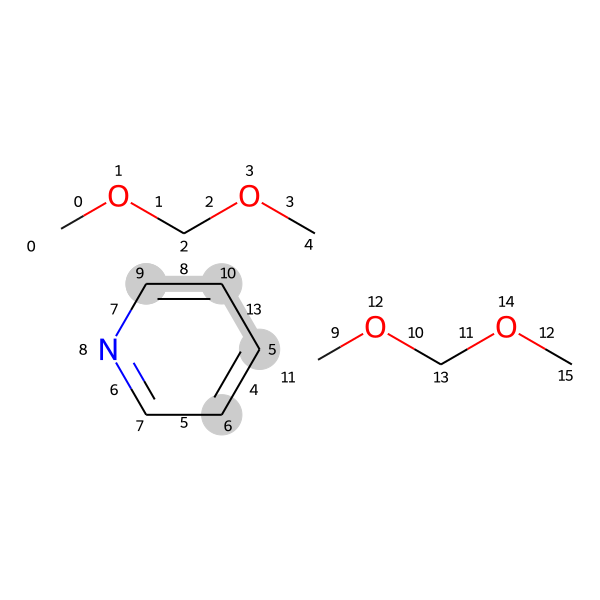

In [4]:
m = Chem.MolFromSmiles('*OCOC.C1=CC=NC=C1.*OCOC |m:0:6.9,11:5.9.10,|')
m

In [7]:
molbundle=rdMolEnumerator.Enumerate(m)


In [13]:
Chem.MolToSmiles(molbundle[4])

'COCOc1(OCOC)ccccn1'

In [44]:
Chem.MolToSmiles(molbundle[0])

'*OCOc1ccnc2c1OCO2'

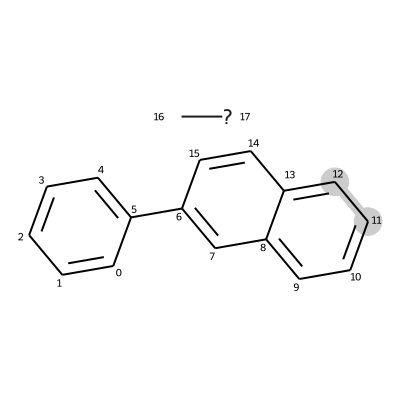

In [16]:
smi="C1=CC=CC=C1C1=CC2=CC=CC=C2C=C1"
mol=Chem.MolFromSmiles(smi)
m1=Chem.MolFromSmiles('C1=CC=CC=C1C1=CC2=CC=CC=C2C=C1.** |m:16:11.12|')
m1

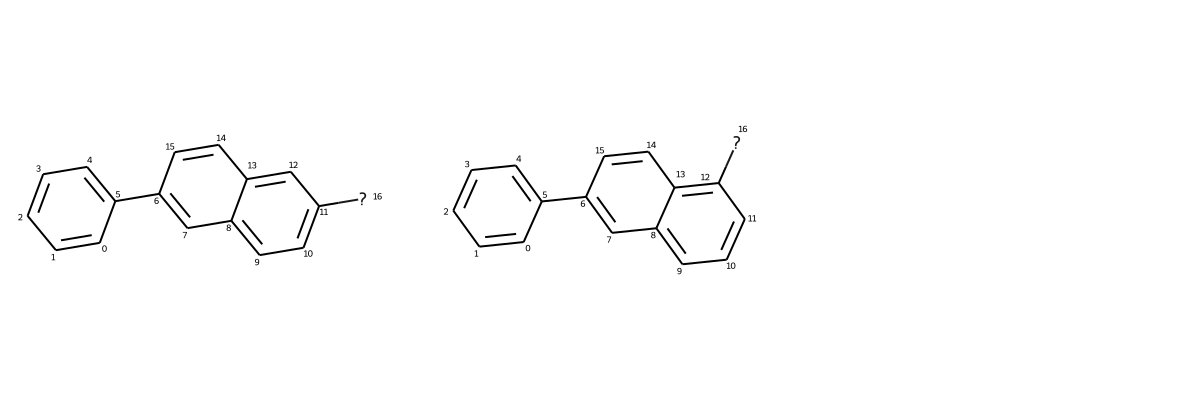

In [17]:
set1=rdMolEnumerator.Enumerate(m1)
set1

In [18]:
Chem.CanonSmiles(Chem.MolToSmiles(set1[0]))

'*c1ccc2cc(-c3ccccc3)ccc2c1'

In [19]:
import rdkit
rdkit.__version__

'2022.03.1'

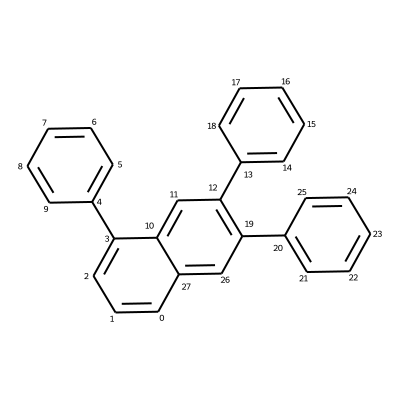

In [45]:
mol=Chem.MolFromSmiles("C1=CC=CC=C1C1=CC2=CC=CC=C2C=C1")
mol

In [21]:
smis_dict=Smi_DummyBond(smi='C1=CC=CC=C1C1=CC2=CC=CC=C2C=C1',bonds=[0,1,2,3])

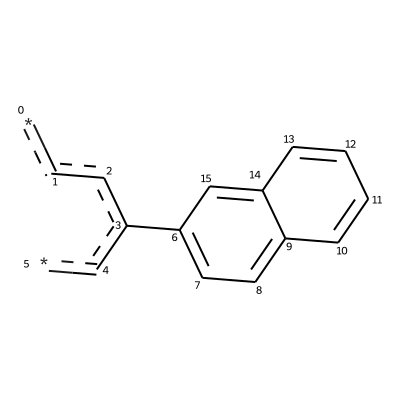

In [22]:
Chem.MolFromSmiles('*:ccc(c:*)-c1ccc2ccccc2c1',False)

In [23]:
smis_dict

{'*:cccc(:*)-c1ccc2ccccc2c1': [0, 5], '*:ccc(c:*)-c1ccc2ccccc2c1': [0, 5]}

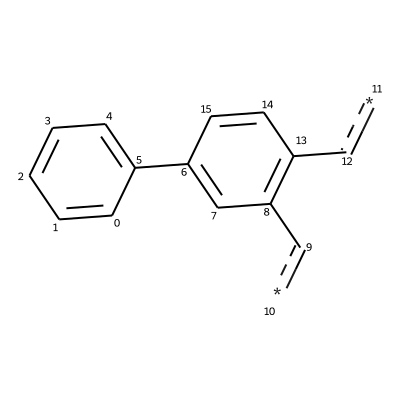

In [24]:
mol=Chem.MolFromSmiles("C1=CC=CC=C1C1=CC2=CC=CC=C2C=C1")
begin=mol.GetBonds()[10].GetBeginAtomIdx()
end=mol.GetBonds()[10].GetEndAtomIdx()
mol1=Chem.rdchem.EditableMol(mol)
mol1.RemoveBond(begin,end)
mol1.ReplaceAtom(begin,Chem.Atom(0))
mol1.ReplaceAtom(end,Chem.Atom(0))	
mol=mol1.GetMol()
mol


In [25]:
core=Chem.MolFromSmiles("C1=CC=CC=C1N(C1=CC=CC=C1)C1=CC=CC=C1")
bond2_atom_begin=core.GetBonds()[2].GetBeginAtomIdx()
bond2_atom_end=core.GetBonds()[2].GetEndAtomIdx()
bond2_atom_begin,bond2_atom_end


(2, 3)

In [26]:
smiles1=Chem.MolToSmiles(mol)
print(smiles1)
smiles2=''.join(Chem.MolToSmiles(mol).split(':'))
print(smiles2)

*:cc1ccc(-c2ccccc2)cc1c:*
*cc1ccc(-c2ccccc2)cc1c*


In [27]:
ligand=Chem.MolFromSmiles(smiles1,sanitize=False)
#获取ligand中虚原子的索引
dummy_atoms=[]
for atom in ligand.GetAtoms():
	if atom.GetAtomicNum()==0:
		dummy_atoms.append(atom.GetIdx())
dummy_atoms

[0, 15]

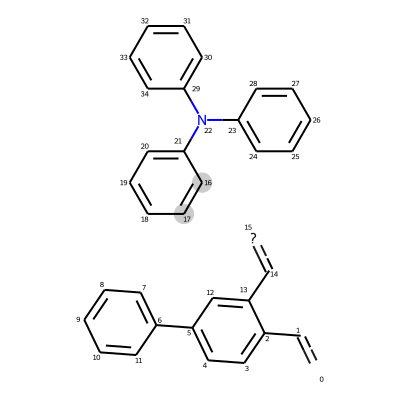

In [28]:
init_enum=Chem.MolFromSmiles("*:cc1ccc(-c2ccccc2)cc1c:*.C1=CC=CC=C1N(C1=CC=CC=C1)C1=CC=CC=C1 |m:0:16,15:17|",sanitize=False)
init_enum

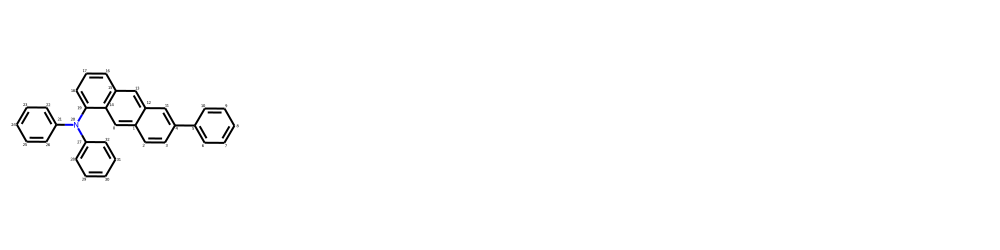

In [29]:
molbundle=rdMolEnumerator.Enumerate(init_enum)
Draw.MolsToGridImage(molbundle,molsPerRow=4,subImgSize=(250,250))

In [30]:
#获取smiles
mol_list=[]
for x in smis:
  mol=Chem.MolFromSmiles(x)
  rdDepictor.Compute2DCoords(mol,nSample=4,permuteDeg4Nodes=True,canonOrient=True)
  mol_list.append(mol)
Draw.MolsToGridImage(mol_list,molsPerRow=4,subImgSize=(250,250))

ArgumentError: Python argument types in
    rdkit.Chem.rdDepictor.Compute2DCoords(NoneType)
did not match C++ signature:
    Compute2DCoords(class RDKit::ROMol {lvalue} mol, bool canonOrient=True, bool clearConfs=True, class boost::python::dict {lvalue} coordMap={}, unsigned int nFlipsPerSample=0, unsigned int nSample=0, int sampleSeed=0, bool permuteDeg4Nodes=False, double bondLength=-1.0, bool forceRDKit=False)

In [ ]:
Chem.MolFromSmiles(smis[1])